<a href="https://colab.research.google.com/github/Vishal1711/behavioural_cloning/blob/master/behavioural_cloning_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [75]:
!git clone https://github.com/Vishal1711/behavioural_cloning

fatal: destination path 'behavioural_cloning' already exists and is not an empty directory.


In [76]:
!ls

behavioural_cloning  sample_data


In [77]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import keras
from keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from keras.layers import Convolution2D, MaxPooling2D, Dropout, Flatten, Dense
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import cv2
import pandas as pd
import ntpath
import random
from imgaug import augmenters as iaa

In [78]:
datadir = 'behavioural_cloning'
columns = ['center', 'left', 'right', 'steering', 'throttle', 'reverse', 'speed']
data = pd.read_csv(os.path.join(datadir, 'driving_log.csv'), names = columns)
pd.set_option('display.max_colwidth', 1)
data.head()

center  ...     speed
0  C:\Users\jadha\Desktop\Udemy SDC\simulator-windows-64\Driving_Data\IMG\center_2021_12_31_13_47_58_439.jpg  ...  0.000079
1  C:\Users\jadha\Desktop\Udemy SDC\simulator-windows-64\Driving_Data\IMG\center_2021_12_31_13_47_58_540.jpg  ...  0.000078
2  C:\Users\jadha\Desktop\Udemy SDC\simulator-windows-64\Driving_Data\IMG\center_2021_12_31_13_47_58_642.jpg  ...  0.000084
3  C:\Users\jadha\Desktop\Udemy SDC\simulator-windows-64\Driving_Data\IMG\center_2021_12_31_13_47_58_742.jpg  ...  0.000082
4  C:\Users\jadha\Desktop\Udemy SDC\simulator-windows-64\Driving_Data\IMG\center_2021_12_31_13_47_58_845.jpg  ...  0.000078

[5 rows x 7 columns]

In [79]:
def path_leaf(path):
    head, tail = ntpath.split(path)
    return tail

data['center'] = data['center'].apply(path_leaf)
data['left'] = data['left'].apply(path_leaf)
data['right'] = data['right'].apply(path_leaf)
data.head()


center  ...     speed
0  center_2021_12_31_13_47_58_439.jpg  ...  0.000079
1  center_2021_12_31_13_47_58_540.jpg  ...  0.000078
2  center_2021_12_31_13_47_58_642.jpg  ...  0.000084
3  center_2021_12_31_13_47_58_742.jpg  ...  0.000082
4  center_2021_12_31_13_47_58_845.jpg  ...  0.000078

[5 rows x 7 columns]

[-1.   -0.92 -0.84 -0.76 -0.68 -0.6  -0.52 -0.44 -0.36 -0.28 -0.2  -0.12
 -0.04  0.04  0.12  0.2   0.28  0.36  0.44  0.52  0.6   0.68  0.76  0.84
  0.92  1.  ]


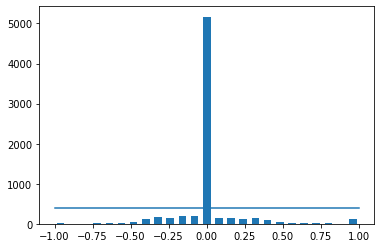

In [81]:
num_bins =25
samples_per_bin = 400
hist, bins = np.histogram(data['steering'], num_bins)
print(bins)
center = (bins[:-1]+ bins[1:]) * 0.5
plt.bar(center, hist, width=0.05)
plt.plot((np.min(data['steering']), np.max(data['steering'])), (samples_per_bin, samples_per_bin))

total data: 7044
removed: 4769
remaining: 2275


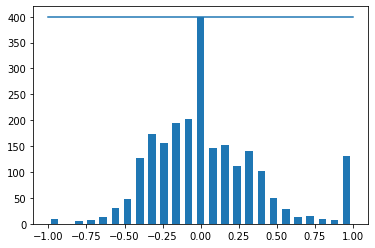

In [82]:
print('total data:', len(data))
remove_list = []
for j in range(num_bins):
  list_ = []
  for i in range(len(data['steering'])):
    if data['steering'][i] >= bins[j] and data['steering'][i] <= bins[j+1]:
      list_.append(i)
  list_ = shuffle(list_)
  list_ = list_[samples_per_bin:]
  remove_list.extend(list_)
 
print('removed:', len(remove_list))
data.drop(data.index[remove_list], inplace=True)
print('remaining:', len(data))
 
hist, _ = np.histogram(data['steering'], (num_bins))
plt.bar(center, hist, width=0.05)
plt.plot((np.min(data['steering']), np.max(data['steering'])), (samples_per_bin, samples_per_bin))

In [83]:
print(data.iloc[1])
def load_img_steering(datadir, df):
  image_path = []
  steering = []
  for i in range(len(data)):
    indexed_data = data.iloc[i]
    center, left, right = indexed_data[0], indexed_data[1], indexed_data[2]
    image_path.append(os.path.join(datadir, center.strip()))
    steering.append(float(indexed_data[3]))
    # left image append
    image_path.append(os.path.join(datadir,left.strip()))
    steering.append(float(indexed_data[3])+0.15)
    # right image append
    image_path.append(os.path.join(datadir,right.strip()))
    steering.append(float(indexed_data[3])-0.15)
  image_paths = np.asarray(image_path)
  steerings = np.asarray(steering)
  return image_paths, steerings
 
image_paths, steerings = load_img_steering(datadir + '/IMG', data)
  


center      center_2021_12_31_13_47_59_656.jpg
left        left_2021_12_31_13_47_59_656.jpg  
right       right_2021_12_31_13_47_59_656.jpg 
steering   -0.0473829                         
throttle    1                                 
reverse     0                                 
speed       2.22748                           
Name: 12, dtype: object


In [84]:
X_train, X_valid, y_train, y_valid = train_test_split(image_paths, steerings, test_size=0.2, random_state=6)
print('Training Samples: {}\nValid Samples: {}'.format(len(X_train), len(X_valid)))

Training Samples: 5460
Valid Samples: 1365


Text(0.5, 1.0, 'Validation set')

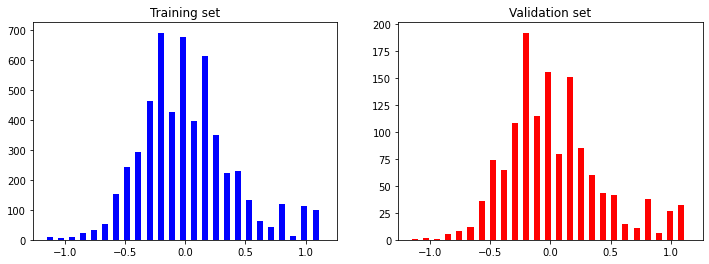

In [85]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].hist(y_train, bins=num_bins, width=0.05, color='blue')
axes[0].set_title('Training set')
axes[1].hist(y_valid, bins=num_bins, width=0.05, color='red')
axes[1].set_title('Validation set')

In [86]:
def zoom(image):
  zoom = iaa.Affine(scale=(1, 1.3))
  image = zoom.augment_image(image)
  return image

Text(0.5, 1.0, 'Zoomed Image')

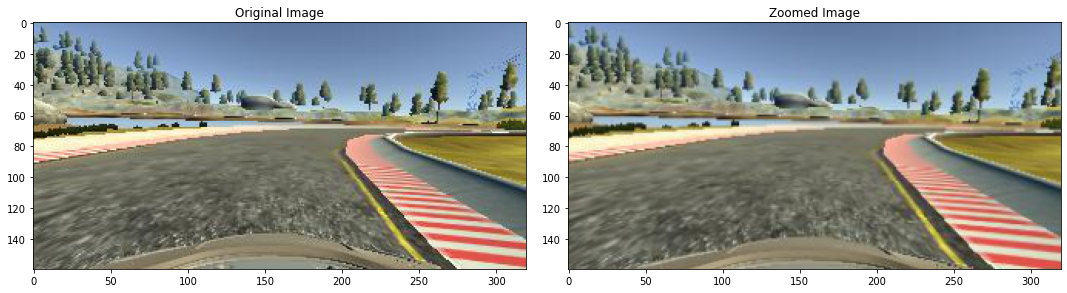

In [87]:
image = image_paths[random.randint(0, 1000)]
original_image = mpimg.imread(image)
zoomed_image = zoom(original_image)
 
fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()
 
axs[0].imshow(original_image)
axs[0].set_title('Original Image')
 
axs[1].imshow(zoomed_image)
axs[1].set_title('Zoomed Image')

In [88]:
def pan(image):
  pan = iaa.Affine(translate_percent={"x" :(-0.1, 0.1),"y" :(-0.1, 0.1)})
  image = pan.augment_image(image)
  return image

Text(0.5, 1.0, 'Panned Image')

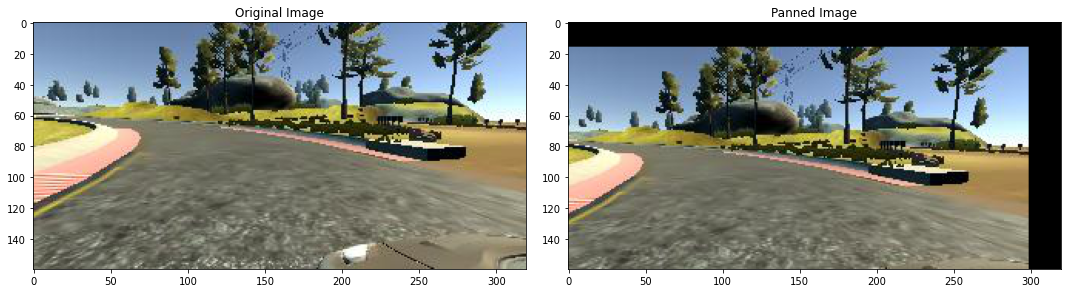

In [89]:
image = image_paths[random.randint(0, 1000)]
original_image = mpimg.imread(image)
panned_image = pan(original_image)
 
fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()

axs[0].imshow(original_image)
axs[0].set_title('Original Image')
 
axs[1].imshow(panned_image)
axs[1].set_title('Panned Image')

In [90]:
def img_random_brightness(image):
  brightness = iaa.Multiply((0.2,1.2))
  image = brightness.augment_image(image)
  return image

Text(0.5, 1.0, 'Brightness Changed Image')

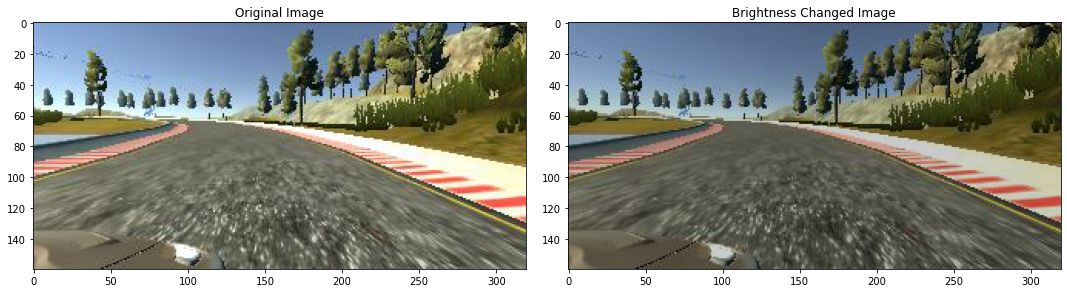

In [91]:
image = image_paths[random.randint(0, 1000)]
original_image = mpimg.imread(image)
brightness_image = img_random_brightness(original_image)
 
fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()

axs[0].imshow(original_image)
axs[0].set_title('Original Image')
 
axs[1].imshow(brightness_image)
axs[1].set_title('Brightness Changed Image')


In [92]:
def img_random_flip(image, steering_angle):
    image = cv2.flip(image,1)
    steering_angle = -steering_angle
    return image, steering_angle

Text(0.5, 1.0, 'Flipped Image - Steering Angle :0.202005')

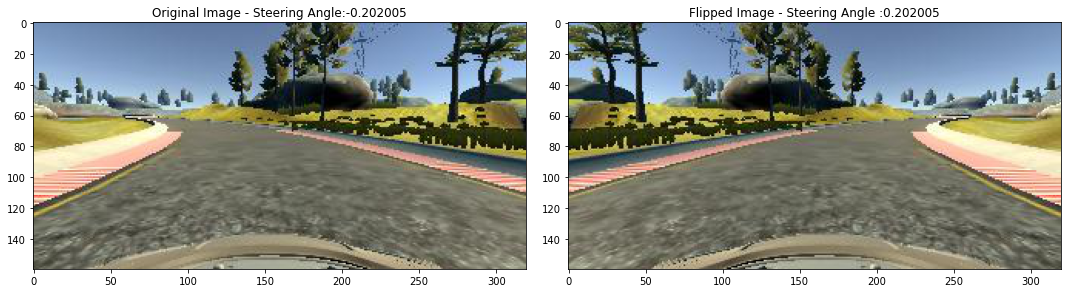

In [93]:
random_index = random.randint(0, 1000)
image = image_paths[random_index]
steering_angle = steerings[random_index]
 
 
original_image = mpimg.imread(image)
flipped_image, flipped_steering = img_random_flip(original_image, steering_angle)
 
fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()
 
axs[0].imshow(original_image)
axs[0].set_title('Original Image - ' + 'Steering Angle:' + str(steering_angle))
 
axs[1].imshow(flipped_image)
axs[1].set_title('Flipped Image - ' + 'Steering Angle :' + str(flipped_steering))

In [94]:
def random_augment(image, steering_angle):
  image = mpimg.imread(image)
  if np.random.rand() < 0.5:
    image = pan(image)
  if np.random.rand() < 0.5:
    image = zoom(image)
  if np.random.rand() < 0.5:
    image = img_random_brightness(image)
  if np.random.rand() < 0.5:
    image, steering_angle = img_random_flip(image, steering_angle)

  return image, steering_angle                              

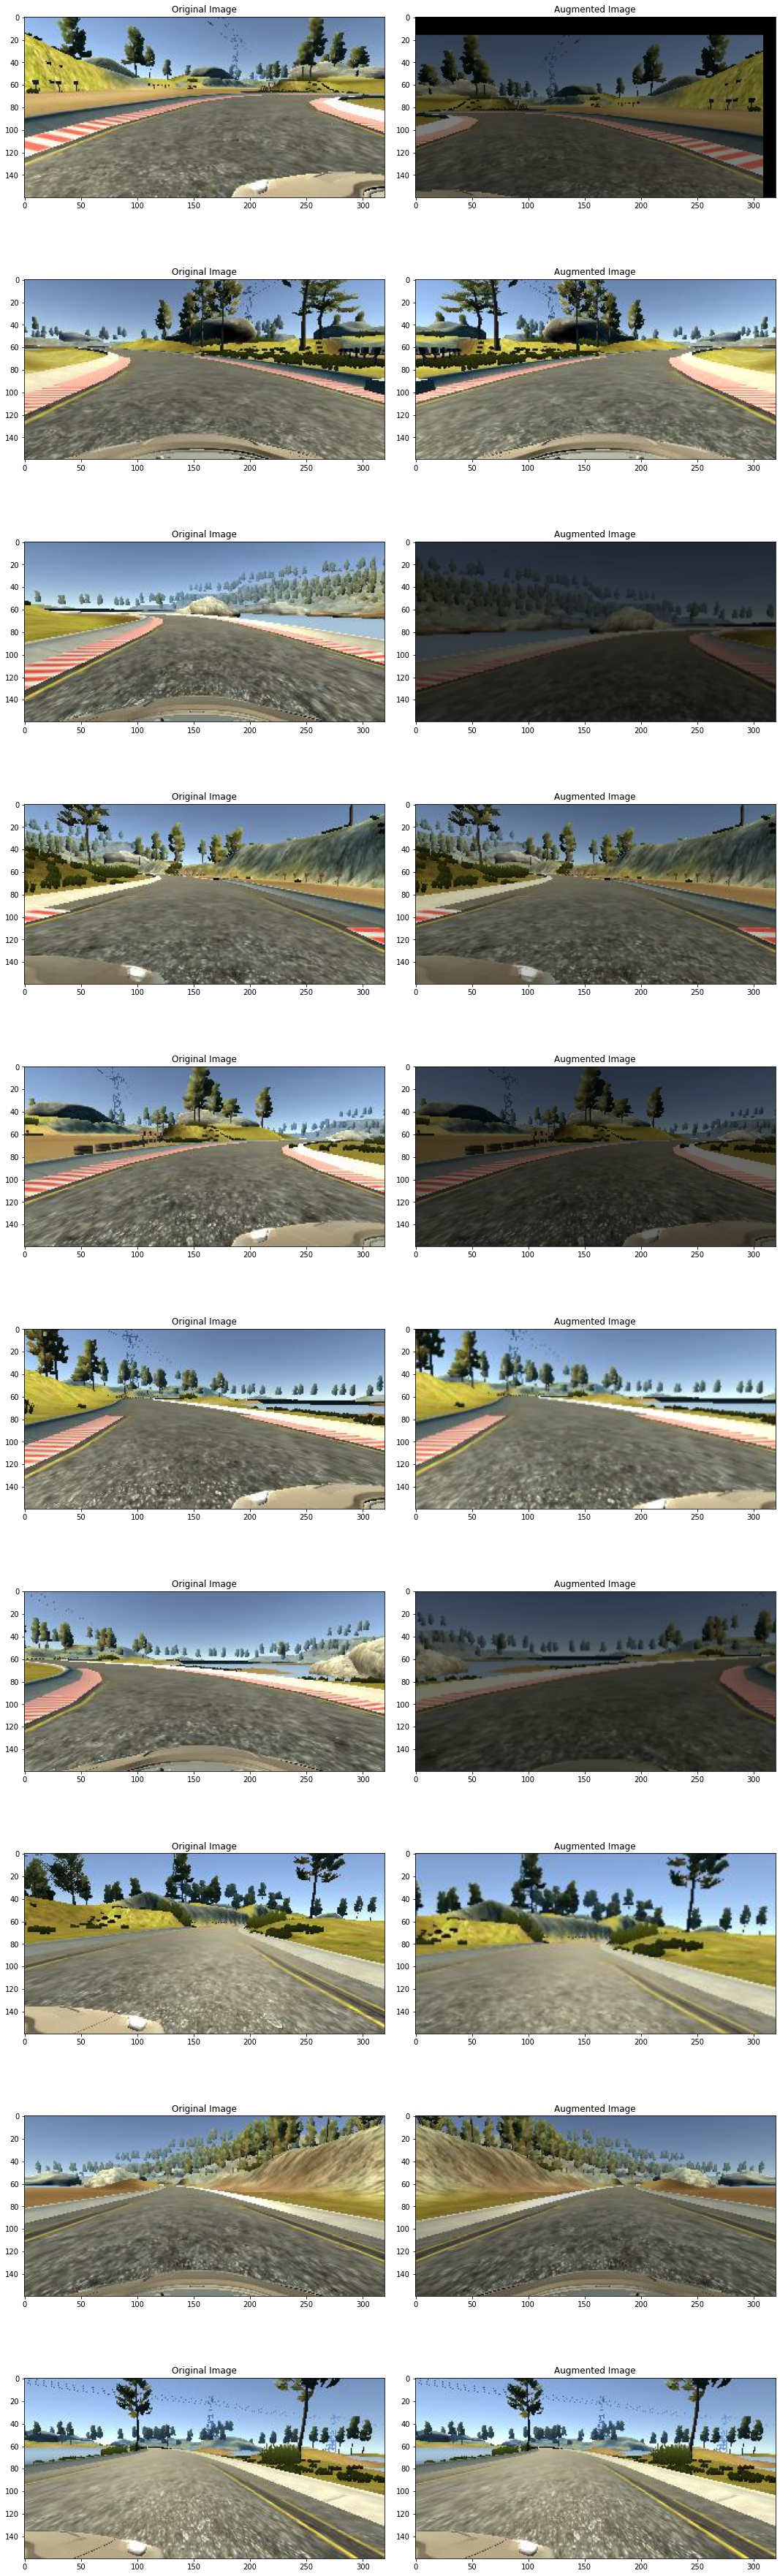

In [95]:
ncol = 2
nrow = 10
 
 
fig, axs = plt.subplots(nrow, ncol, figsize=(15, 50))
fig.tight_layout()

for i in range(10):
  randnum = random.randint(0, len(image_paths) - 1)
  random_image = image_paths[randnum]
  random_steering = steerings[randnum]
    
  original_image = mpimg.imread(random_image)
  augmented_image, steering = random_augment(random_image, random_steering)
    
  axs[i][0].imshow(original_image)
  axs[i][0].set_title("Original Image")
  axs[i][1].imshow(augmented_image)
  axs[i][1].set_title("Augmented Image")

In [96]:
def img_preprocessing(img):
  img = img[60:137,:,: ]
  img = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
  img = cv2.GaussianBlur(img, (3,3), 0)
  img = cv2.resize(img, (200,66))
  img = img/255
  return img

Text(0.5, 1.0, 'preprocessed_image')

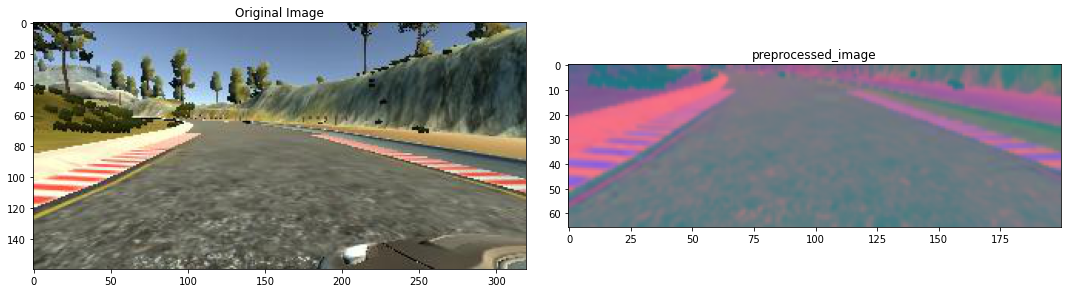

In [97]:
image = image_paths[103]
original_image = mpimg.imread(image)
preprocessed_image = img_preprocessing(original_image)

fig, axs = plt.subplots(1, 2, figsize=(15,10))
fig.tight_layout()
 
axs[0].imshow(original_image)
axs[0].set_title('Original Image')
 
axs[1].imshow(preprocessed_image)
axs[1].set_title('preprocessed_image')

In [98]:
def batch_generator(image_paths, steering_ang, batch_size, istraining):
  
  while True:
    batch_img = []
    batch_steering = []
    for i in range(batch_size):
      random_index = random.randint(0, len(image_paths) - 1)
      
      if istraining:
        im, steering = random_augment(image_paths[random_index], steering_ang[random_index])
     
      else:
        im = mpimg.imread(image_paths[random_index])
        steering = steering_ang[random_index]
      
      im = img_preprocessing(im)
      batch_img.append(im)
      batch_steering.append(steering)
    yield (np.asarray(batch_img), np.asarray(batch_steering))  

Text(0.5, 1.0, 'Validation Image')

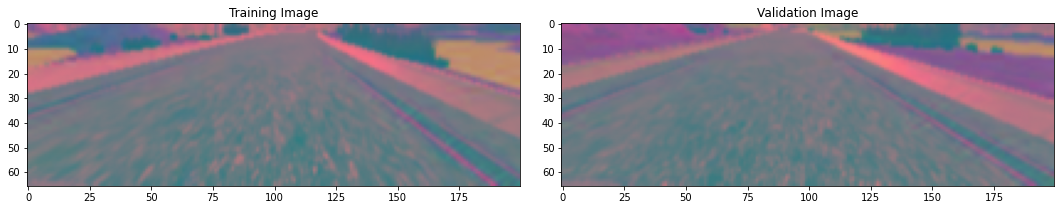

In [99]:
x_train_gen, y_train_gen = next(batch_generator(X_train, y_train, 1, 1))
x_valid_gen, y_valid_gen = next(batch_generator(X_valid, y_valid, 1, 0))

fig, axs = plt.subplots(1, 2, figsize=(15,10))
fig.tight_layout()
 
axs[0].imshow(x_train_gen[0])
axs[0].set_title('Training Image')
 
axs[1].imshow(x_valid_gen[0])
axs[1].set_title('Validation Image')

In [ ]:
# X_train = np.array(list(map(img_preprocessing, X_train)))
# X_valid = np.array(list(map(img_preprocessing, X_valid)))
# plt.imshow(X_train[random.randint(0, len(X_train)-1)])
# plt.axis('off')
# print(X_train.shape)

In [100]:
def nvidia_model():
  model = Sequential()
  model.add(Convolution2D(24, kernel_size=(5,5), strides=(2,2), input_shape=(66,200,3), activation='elu'))
  model.add(Convolution2D(36, kernel_size=(5, 5), strides=(2,2), activation='relu'))
  model.add(Convolution2D(48, kernel_size=(5, 5), strides=(2,2), activation='relu'))
  model.add(Convolution2D(64, kernel_size=(3, 3), activation='relu'))
  model.add(Convolution2D(64, kernel_size=(3, 3), activation='relu'))

  model.add(Flatten())
  model.add(Dense(100, activation='relu'))

  model.add(Dense(50, activation='relu'))
  model.add(Dense(10, activation='relu'))
  model.add(Dense(1))
  optimizer = Adam(learning_rate=0.001)
  model.compile(loss='mse', optimizer=optimizer)
  return model

In [101]:
model = nvidia_model()
print(model.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 31, 98, 24)        1824      
                                                                 
 conv2d_11 (Conv2D)          (None, 14, 47, 36)        21636     
                                                                 
 conv2d_12 (Conv2D)          (None, 5, 22, 48)         43248     
                                                                 
 conv2d_13 (Conv2D)          (None, 3, 20, 64)         27712     
                                                                 
 conv2d_14 (Conv2D)          (None, 1, 18, 64)         36928     
                                                                 
 flatten_2 (Flatten)         (None, 1152)              0         
                                                                 
 dense_8 (Dense)             (None, 100)              

In [102]:
history = model.fit_generator(batch_generator(X_train, y_train, 100, 1), steps_per_epoch=200, epochs=10, validation_data=batch_generator(X_valid, y_valid, 100, 0), validation_steps=200,verbose=1,
                                  shuffle = 1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  


Epoch 1/10
200/200 [==============================] - 161s 807ms/step - loss: 0.1241 - val_loss: 0.0958
Epoch 2/10
200/200 [==============================] - 158s 793ms/step - loss: 0.0988 - val_loss: 0.0580
Epoch 3/10
200/200 [==============================] - 157s 791ms/step - loss: 0.0836 - val_loss: 0.0531
Epoch 4/10
200/200 [==============================] - 159s 797ms/step - loss: 0.0704 - val_loss: 0.0528
Epoch 5/10
200/200 [==============================] - 157s 790ms/step - loss: 0.0666 - val_loss: 0.0473
Epoch 6/10
200/200 [==============================] - 158s 791ms/step - loss: 0.0643 - val_loss: 0.0418
Epoch 7/10
200/200 [==============================] - 158s 794ms/step - loss: 0.0566 - val_loss: 0.0463
Epoch 8/10
200/200 [==============================] - 157s 789ms/step - loss: 0.0546 - val_loss: 0.0459
Epoch 9/10
200/200 [==============================] - 157s 791ms/step - loss: 0.0670 - val_loss: 0.0424
Epoch 10/10
200/200 [==============================] - 157s 789m

Text(0.5, 0, 'Epoch')

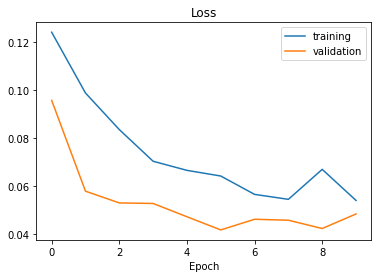

In [103]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['training', 'validation'])
plt.title('Loss')
plt.xlabel('Epoch')

In [106]:
model.save('model.h5')

from google.colab import files
files.download('model.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>